In [1]:
from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone

track = MIST_EvolutionTrack()

In [2]:
from isochrones import SingleStarModel, get_ichrone

mist = get_ichrone('mist')

In [30]:
from scipy.stats import norm
import numpy as np
import pandas as pd

def loglikelihood(x, data):
  likelihood = 0
#   age, feh, distance, AV, *masses = x
  age, feh, AV, *masses = x
  for mass, dat in zip(masses, data):
      distance= 1000/dat['parallax'][0]
      true_props = track.generate(mass, age, feh, distance=distance, AV=AV, return_dict=True)
      for name in dat:
          if(name == "parallax"): 
              continue
          if(np.isnan(true_props[name])): return -np.inf
          likelihood += norm.logpdf(true_props[name], loc=dat[name][0], scale=dat[name][1])
  return likelihood

-14079581.295148594


/tmp/ipykernel_97206/1929418195.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(AVPrior(AV))+


-inf

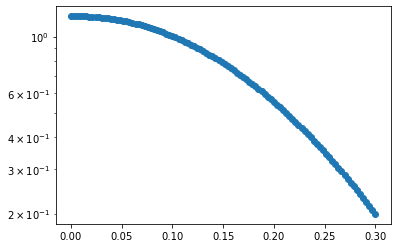

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns

ONE_OVER_ROOT_2PI = 1/(2*np.pi)

def MassPrior(mass):
    if isinstance(mass, np.ndarray) or isinstance(mass, list):
        return np.array(list(map(MassPrior, mass)))
    if(mass <=0):
        return 0
    if(mass <=1):
        # return norm.logpdf(mass, loc=0.079, scale=0.69)
        scale = np.exp(0.079)
        s = 0.69
        y = mass/scale
        return ONE_OVER_ROOT_2PI / (s * y) * np.exp(-0.5 * (np.log(y) / s) ** 2) / scale
    return 0.22915247201304262*np.power(mass, -2.35)
def DistancePrior(distance):
    if isinstance(distance, np.ndarray) or isinstance(distance, list):
        return np.array(list(map(DistancePrior, distance)))
    if distance < 10_000 and distance >=0:
        return 3*np.power(distance, 2)/10_000**3
    return 0
def AgePrior(age):
    if isinstance(age, np.ndarray) or isinstance(age, list):
        return np.array(list(map(AgePrior, age)))
    if age > 5 and age < 10.5:
        return 1/(10.5-5)
    return 0
def AVPrior(AV):
    if isinstance(AV, np.ndarray) or isinstance(AV, list):
        return np.array(list(map(AVPrior, AV)))
    if AV >= 0 and AV <= 1:
        return 1
    return 0
def FehPrior(feh):
    if isinstance(feh, np.ndarray) or isinstance(feh, list):
        return np.array(list(map(FehPrior, feh)))
    halo_fraction=0.5
    disk_norm = 2.5066282746310007  # integral of the below from -np.inf to np.inf
    disk_fehdist = (
      1.0
      / disk_norm
      * (
          0.8 / 0.15 * np.exp(-0.5 * (feh - 0.016) ** 2.0 / 0.15 ** 2.0)
          + 0.2 / 0.22 * np.exp(-0.5 * (feh + 0.15) ** 2.0 / 0.22 ** 2.0)
      )
    )
    halo_mu, halo_sig = -1.5, 0.4
    halo_fehdist = (
      1.0 / np.sqrt(2 * np.pi * halo_sig ** 2) * np.exp(-0.5 * (feh - halo_mu) ** 2 / halo_sig ** 2)
    )

    return halo_fraction * halo_fehdist + (1 - halo_fraction) * disk_fehdist
xx = np.linspace(0,0.3,100)
# ages = 1000
prob = FehPrior(xx)
prob
plt.scatter(xx, prob)
plt.yscale("log")

In [43]:
def logprior(x):
    age, feh, AV, *masses = x
    value = (np.log(AgePrior(age))+
             np.log(FehPrior(feh))+
            #  np.log(DistancePrior(distance))+
             np.log(AVPrior(AV))+
             np.sum(np.log(MassPrior(masses))))
    return value

0.18181818181818182
9.5


/tmp/ipykernel_97206/3559948979.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(AVPrior(AV))+


(9.5, 0.3, 1228.3845992020583, 0.0, 1.5)

In [33]:
def logposterior(x, data):
    return loglikelihood(x, data) + logprior(x)

In [12]:
result = pd.read_csv("FSR_0866.csv")
result

,Unnamed: 0,g,g_error,r,r_error,b,b_error,parallax,parallax_error
0,0,11.278003,0.000529,10.575042,0.000652,11.874046,0.002036,0.787126,0.040036
1,1,12.160135,0.000232,11.803123,0.000792,12.372580,0.001880,0.798561,0.037741
2,2,12.511895,0.000231,11.850567,0.000917,13.050261,0.002017,0.840251,0.039577
3,3,12.679243,0.000360,12.401573,0.001443,12.834153,0.001855,0.851589,0.035360
4,4,13.133636,0.000764,12.620711,0.001752,13.481897,0.002662,0.780182,0.023758
...,...,...,...,...,...,...,...,...,...
60,60,16.623377,0.001141,15.956081,0.003543,17.156321,0.012114,0.903863,0.084285
61,61,16.876169,0.001097,16.184484,0.005779,17.428289,0.009050,0.720091,0.078177
62,62,17.019424,0.001060,16.307314,0.004475,17.605822,0.009935,0.917363,0.088883
63,63,17.162193,0.000984,16.415089,0.007368,17.790096,0.012780,0.753428,0.098942


In [13]:
result['b-r'] = result["b"] - result["r"]
result

,Unnamed: 0,g,g_error,r,r_error,b,b_error,parallax,parallax_error,b-r
0,0,11.278003,0.000529,10.575042,0.000652,11.874046,0.002036,0.787126,0.040036,1.299005
1,1,12.160135,0.000232,11.803123,0.000792,12.372580,0.001880,0.798561,0.037741,0.569456
2,2,12.511895,0.000231,11.850567,0.000917,13.050261,0.002017,0.840251,0.039577,1.199694
3,3,12.679243,0.000360,12.401573,0.001443,12.834153,0.001855,0.851589,0.035360,0.432580
4,4,13.133636,0.000764,12.620711,0.001752,13.481897,0.002662,0.780182,0.023758,0.861186
...,...,...,...,...,...,...,...,...,...,...
60,60,16.623377,0.001141,15.956081,0.003543,17.156321,0.012114,0.903863,0.084285,1.200239
61,61,16.876169,0.001097,16.184484,0.005779,17.428289,0.009050,0.720091,0.078177,1.243805
62,62,17.019424,0.001060,16.307314,0.004475,17.605822,0.009935,0.917363,0.088883,1.298508
63,63,17.162193,0.000984,16.415089,0.007368,17.790096,0.012780,0.753428,0.098942,1.375008


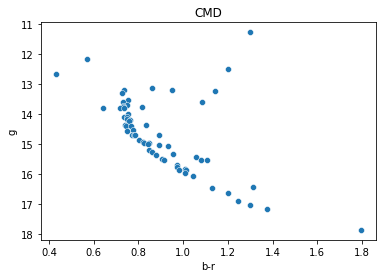

In [14]:
sns.scatterplot(x="b-r", y="g", data=result)
plt.title("CMD")
plt.gca().invert_yaxis()

[2, 5, 6, 7, 11, 12, 13, 21, 23, 24, 27, 29, 34, 37, 38, 50, 51, 52, 53, 54]


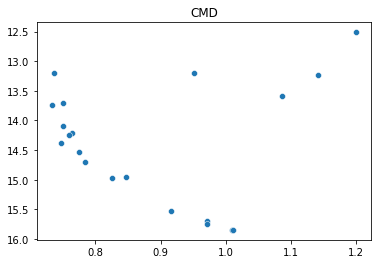

In [15]:
from numpy.random import default_rng

rng = default_rng()
# numbers = rng.choice(len(result), size=20, replace=False)
# numbers = [198, 208, 638, 0, 333, 592,  93, 621,  19, 662, 164, 395, 664, 362, 263, 140, 76, 215, 354, 139]
numbers = [2,  11,  6,  7, 12, 13, 21, 23, 24, 27, 29, 34, 37, 38, 5, 50, 51, 53, 54, 52]
numbers.sort()
print(numbers)
G = result['g']
B = result['b']
R = result['r']
prop = []

for i in numbers:
    props = {
        'G_mag': (result['g'][i], result['g_error'][i]),
        'RP_mag': (result['r'][i], result['r_error'][i]),
        'BP_mag': (result['b'][i], result['b_error'][i]),
        'parallax': (result['parallax'][i], result['parallax_error'][i]),
    }
    prop.append(props)
prop
g = []
r = []
b = []
for p in prop:
    g.append(p['G_mag'][0])
    r.append(p['RP_mag'][0])
    b.append(p['BP_mag'][0])

g = np.array(g)
r = np.array(r)
b = np.array(b)

# sns.scatterplot(x="b-r", y="g", data=result)
sns.scatterplot(x=b-r, y=g)
plt.title("CMD")
plt.gca().invert_yaxis()
# nn = 46
# plt.scatter(x=(result['b']-result['r']).loc[nn], y=result['g'].loc[nn], c="r")

In [16]:
from astroquery.vizier import Vizier
from isochrones.mist import MIST_Isochrone
from isochrones import SingleStarModel, get_ichrone

mist = get_ichrone('mist')
Mist = MIST_Isochrone()

In [17]:
prl = np.mean(result["parallax"])
dist = 1000/prl
dist

1228.3845992020583

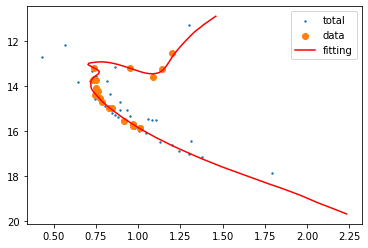

In [244]:
g_mod, r_mod, b_mod = np.array([]), np.array([]), np.array([])
pivot = 1.45
delta_pivot =0.08
MASSES = np.linspace(0.5, pivot, 50)
MASSES2 = np.linspace(pivot, pivot+delta_pivot, 100)
MASSES = np.concatenate((MASSES,MASSES2), axis=0)
fage, ffeh, fdistance, fAV = 9.5, 0.3, dist, 0.
for mass in MASSES:
    eep = mist.get_eep(mass, fage, ffeh, accurate=True)
    pars = [eep, fage, ffeh, fdistance, fAV]
    # pars = [353, 9.78, -1.24]  # eep, log(age), feh
    v = Mist.interp_mag(pars, ['G', 'RP', 'BP'])
    g_i, r_i, b_i = v[-1]
    g_mod = np.append(g_mod, g_i)
    r_mod = np.append(r_mod, r_i)
    b_mod = np.append(b_mod, b_i)
    
plt.scatter(B-R, G, label="total", s=2)
plt.scatter(b-r, g, label="data")

plt.plot(b_mod-r_mod, g_mod, label="fitting", c="r")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

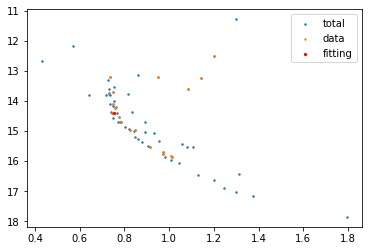

In [202]:
g_mod, r_mod, b_mod = np.array([]), np.array([]), np.array([])
bawah = masses[9]
delta_pivot =0.0001
MASSES = np.linspace(bawah, bawah+delta_pivot, 1)
fage, ffeh, fdistance, fAV = 9.5, 0.3, dist, 0.
for mass in MASSES:
    eep = mist.get_eep(mass, fage, ffeh, accurate=True)
    pars = [eep, fage, ffeh, fdistance, fAV]
    # pars = [353, 9.78, -1.24]  # eep, log(age), feh
    v = Mist.interp_mag(pars, ['G', 'RP', 'BP'])
    g_i, r_i, b_i = v[-1]
    g_mod = np.append(g_mod, g_i)
    r_mod = np.append(r_mod, r_i)
    b_mod = np.append(b_mod, b_i)
    
plt.scatter(B-R, G, label="total", s=2)
plt.scatter(b-r, g, label="data", s = 2)

plt.scatter(b_mod-r_mod, g_mod, label="fitting", c="r", s=5, marker='x')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [245]:
masses = [1.511, 1.4975, 1.491, 1.485, 1.462, 1.345, 1.345, 1.25, 1.225, 1.225, 1.225, 1.21, 
1.14, 1.095, 1.08, 1.01, 0.97, 0.97, 0.945, 0.945]
len(masses)

20

In [204]:
len(prop)

20

In [247]:
# masses = rng.choice(np.linspace(0.5,1.5,1000), size=20, replace=False)
# masses = [1.51]
base = 0
mass = masses[base:base+1]
age, feh, AV = fage, ffeh, 0.3
x = (age, feh, AV, *mass)
logposterior(x, [prop[0]])

-329306.6582567255

In [249]:
len(x)

4

In [262]:
nwalkers = len(x)*5
ndim = len(x)
p0 = []
mult = np.array([0.1,1, 0.1])

mass_mult = np.ones(len(x)-3)*0.01
mult = np.concatenate((mult, mass_mult), axis=0)
for p in range(nwalkers):
    dev = (np.random.rand(ndim)-0.5)*2
    val = np.array([age, feh, AV, *mass])+dev*mult
    p0.append(val)

In [207]:
p0[:5]

[array([ 9.58613794, -0.65782037,  0.54676825,  1.48317234,  1.45992697,
         1.45050936,  1.44056743,  1.50667376,  1.34799356,  1.31668859,
         1.28637718,  1.24609995,  1.17573946,  1.26317686,  1.21165388,
         1.09925875,  1.05117492,  1.03063638,  0.99187557,  0.93175877,
         1.00451096,  0.97860191,  0.97867485]),
 array([9.45496858, 0.72205918, 0.41397798, 1.53570554, 1.4933546 ,
        1.45503288, 1.45274268, 1.43808131, 1.37412489, 1.34857624,
        1.27836454, 1.19344065, 1.20608518, 1.18879698, 1.22552621,
        1.16472731, 1.05399715, 1.12145401, 0.97324769, 1.01526654,
        0.9666238 , 0.95484007, 0.90530851]),
 array([9.47668018, 1.25690814, 0.46543954, 1.47294686, 1.51809052,
        1.5217684 , 1.47426034, 1.44834855, 1.33659536, 1.31377677,
        1.22971145, 1.2740655 , 1.17883247, 1.22394713, 1.21242826,
        1.14005418, 1.10587211, 1.06341535, 1.05998537, 0.94315943,
        0.96791145, 0.9408668 , 0.92555887]),
 array([ 9.54132212, -0

In [263]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[prop])

In [274]:
prop

[{'G_mag': (12.511895179748535, 0.0002310287527507),
  'RP_mag': (11.850566864013672, 0.0009169980767183),
  'BP_mag': (13.050260543823242, 0.002017410704866),
  'parallax': (0.840250878856199, 0.03957665817605)},
 {'G_mag': (13.195191383361816, 0.0004337310965638),
  'RP_mag': (12.746417045593262, 0.0011595451505854),
  'BP_mag': (13.483648300170898, 0.0017431377200409),
  'parallax': (0.8351640229215387, 0.0326866097821778)},
 {'G_mag': (13.195511817932127, 0.0003286275605205),
  'RP_mag': (12.642366409301758, 0.0014008251018822),
  'BP_mag': (13.593159675598145, 0.0020298245362937),
  'parallax': (0.8504178113325365, 0.0242193044132422)},
 {'G_mag': (13.235563278198242, 0.000430454063462),
  'RP_mag': (12.595377922058104, 0.0014855609042569),
  'BP_mag': (13.736712455749512, 0.002410853980109),
  'parallax': (0.8068851146580691, 0.029507540295966)},
 {'G_mag': (13.592894554138184, 0.0003943702904507),
  'RP_mag': (12.970781326293944, 0.0027356015052646),
  'BP_mag': (14.056581497192

In [264]:
%%time
state = sampler.run_mcmc(p0, 1000)

/home/alisyaifudin/Documents/isochrone/emcee/src/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/tmp/ipykernel_110659/2713515247.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(AVPrior(AV))+


CPU times: user 7.17 s, sys: 44 µs, total: 7.17 s
Wall time: 7.18 s


Text(0.5, 0, 'step number')

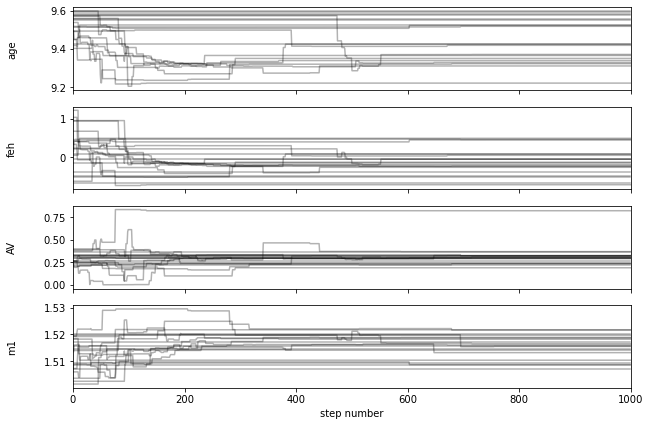

In [265]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["age", "feh", "AV", 'm1']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

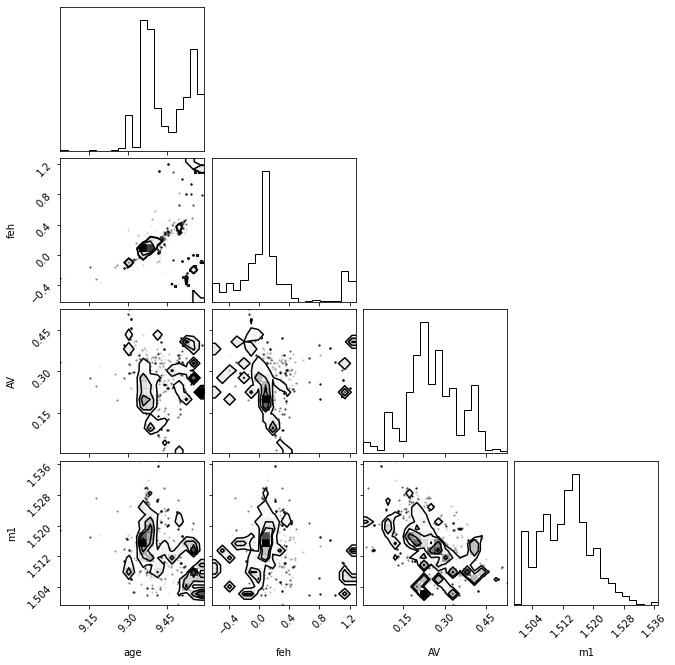

In [220]:
import corner

samples = sampler.get_chain(discard=150, flat=True)
samples = sampler.get_chain(flat=True)
fig = corner.corner(
    samples[:,:4], labels=labels
)

In [266]:
sampler.reset()

In [267]:
%%time

sampler.run_mcmc(state, 10000)

/home/alisyaifudin/Documents/isochrone/emcee/src/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/tmp/ipykernel_110659/2713515247.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(AVPrior(AV))+


CPU times: user 1min 26s, sys: 72 ms, total: 1min 26s
Wall time: 1min 26s


State([[ 9.34608060e+00 -1.79090360e-01  3.12161784e-01  1.51442482e+00]
 [ 9.22097358e+00 -7.15532408e-01  8.21082196e-01  1.52176302e+00]
 [ 9.59228821e+00 -5.15048118e-01  3.69423771e-01  1.51470261e+00]
 [ 9.40288593e+00  1.10046755e-03  3.17549926e-01  1.51660444e+00]
 [ 9.35684349e+00 -9.18452125e-02  3.03100015e-01  1.51678467e+00]
 [ 9.55663356e+00 -4.97901426e-01  2.61172678e-01  1.50935391e+00]
 [ 9.32852484e+00 -2.49798214e-01  3.59135617e-01  1.50895635e+00]
 [ 9.55265288e+00 -1.50766274e-01  2.23181425e-01  1.51561193e+00]
 [ 9.58345046e+00 -3.76121717e-01  2.93698334e-01  1.50840022e+00]
 [ 9.42416410e+00  7.90302916e-02  2.94506208e-01  1.51429174e+00]
 [ 9.59557462e+00 -4.21984199e-02  2.41395940e-01  1.51733359e+00]
 [ 9.42692990e+00  1.27454392e-01  3.20830124e-01  1.51400047e+00]
 [ 9.42407994e+00  7.80194285e-02  2.89985764e-01  1.51422754e+00]
 [ 9.34423448e+00 -1.85887788e-01  3.25229452e-01  1.51575432e+00]
 [ 9.34509446e+00 -1.92963038e-01  3.28947358e-01  1.511

Text(0.5, 0, 'step number')

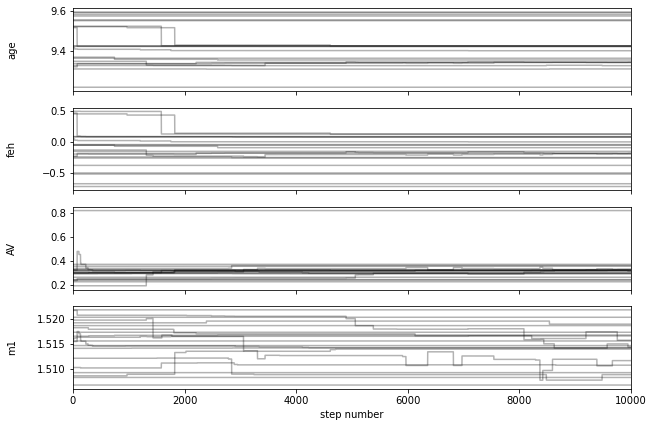

In [269]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["age", "feh", "AV", 'm1']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

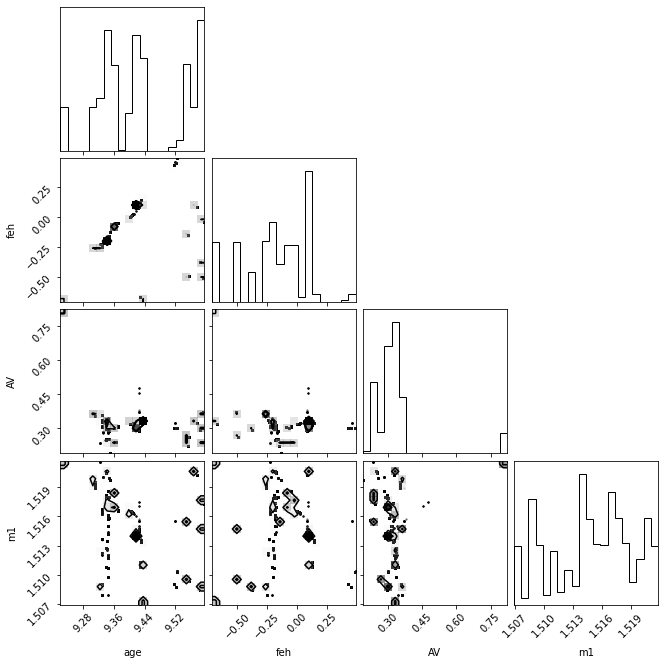

In [270]:
import corner

samples = sampler.get_chain(discard=2000, flat=True)
samples = sampler.get_chain(flat=True)
fig = corner.corner(
    samples[:,:4], labels=labels
)

[]

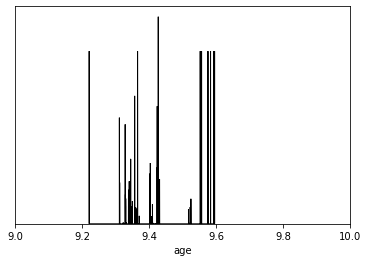

In [273]:
plt.hist(samples[:, 0], bins=5000, color="k", histtype="step")
plt.xlabel("age")
plt.xlim(9, 10)
plt.gca().set_yticks([])

In [271]:
fage, ffeh, fAV = (np.median(samples[:, 0]), 
                              np.median(samples[:, 1]), 
                              np.median(samples[:, 2]))
fage, ffeh, fAV

(9.424164214235473, -0.15076627356090083, 0.3162322640725746)

In [272]:
g_mod, r_mod, b_mod = np.array([]), np.array([]), np.array([])
pivot = 1.51
delta_pivot =0.08
MASSES = np.linspace(0.8, pivot, 50)
MASSES2 = np.linspace(pivot, pivot+delta_pivot, 100)
MASSES = np.concatenate((MASSES,MASSES2), axis=0)
for mass in MASSES:
    eep = mist.get_eep(mass, fage, ffeh, accurate=True)
    pars = [eep, fage, ffeh, dist, fAV]
    # pars = [353, 9.78, -1.24]  # eep, log(age), feh
    v = Mist.interp_mag(pars, ['G', 'RP', 'BP'])
    g_i, r_i, b_i = v[-1]
    g_mod = np.append(g_mod, g_i)
    r_mod = np.append(r_mod, r_i)
    b_mod = np.append(b_mod, b_i)
plt.scatter(b-r, g, label="data")
plt.plot(b_mod-r_mod, g_mod, label="fitting", c="r")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

RuntimeError: EEP minimization not successful: (1.5221212121212122, 9.424164214235473, -0.15076627356090083)